# Evaluation 

In [2]:
import os
import numpy as np
import sklearn
from sklearn import metrics
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import pandas as pd 

In [3]:
from config import *

## Imports

In [ ]:
#TODO maybe we can use only .npy files instead of using pickles

In [ ]:
#TODO add arguments from command line

In [ ]:
#TODO take dataset path from command line 

In [ ]:
#TODO take model from command line

In [ ]:
#TODO implement a verbose output 

### Set paths

In [5]:
# TODO make path config in a dedicated file

# dataset and model for evaluation 
DATASET = 'dos_mqtt_iot'
MODEL = 'xgb'

# set root paths
DATASET_ROOT = os.path.join(ROOT, DATASET)
FILES = os.path.join(DATASET_ROOT, "dataset")
MODELS = os.path.join(DATASET_ROOT, "models")
TARGET_MODEL = os.path.join(MODELS, MODEL)

#set path to test set
#TODO TEST_X = os.path.join(FILES, "test_set.csv")
TEST_X = "../test_set.csv"

# set paths to labels
TEST_Y = os.path.join(FILES, "labels/test_y.npy")
TEST_SEQ = os.path.join(FILES, "labels/test_sequences.pkl")
TEST_MULTI = os.path.join(FILES, "labels/test_multi_label.npy")

# set paths to model predictions
PREDS_PROBA = os.path.join(TARGET_MODEL, "preds/preds_proba.npy") 
PREDS = os.path.join(TARGET_MODEL, "preds/preds.npy")

In [7]:
print("Dataset:  {}, \nModel:  {}".format(DATASET, MODEL))

#verbose
print("Dataset path:  {}, \nModel path:  {}".format(FILES, TARGET_MODEL))
print("test_y path:  {}, \ntest_seq path:  {}, \ntest_multi path {}".format(TEST_Y, TEST_SEQ, TEST_MULTI))
print("preds_proba path:  {}, \npreds path:  {}".format(PREDS_PROBA, PREDS))
print(PRINT_SEPARATOR)

Dataset:  dos_mqtt_iot, 
Model:  xgb
Dataset path:  ./data/dos_mqtt_iot/dataset, 
Model path:  ./data/dos_mqtt_iot/models/xgb
test_y path:  ./data/dos_mqtt_iot/dataset/labels/test_y.npy, 
test_seq path:  ./data/dos_mqtt_iot/dataset/labels/test_sequences.pkl, 
test_multi path ./data/dos_mqtt_iot/dataset/labels/test_multi_label.npy
preds_proba path:  ./data/dos_mqtt_iot/models/xgb/preds/preds_proba.npy, 
preds path:  ./data/dos_mqtt_iot/models/xgb/preds/preds.npy
--------------------------------------------------------------------------------------------------------------------


### Import test set

In [6]:
test_df = pd.read_csv(TEST_X, usecols=['timestamp'])

### Import labels and preds

In [7]:
# test_y: test binary label
# test_multi_label: test label for multi class tasks   
# test_sequences_idx: list of array containing indexes identifying each data point in an attack/error sequence. 
test_y = np.load(TEST_Y)
test_multi_label = np.load(TEST_MULTI, allow_pickle=True)
test_sequences_idx = np.load(TEST_SEQ, allow_pickle=True)

In [60]:
#preds_proba: prediction probabilities vectors of the model
#preds. binary classification balanced by the model
preds_proba = np.load(PREDS_PROBA)
preds = np.load(PREDS)

## Process test set

### Save timestamp

In [61]:
#TODO recognize date time format 

In [8]:
test_df['timestamp'] = pd.to_datetime(test_df['timestamp'], format='%Y-%m-%d %H:%M:%S.%f')

In [9]:
test_timestamp = test_df['timestamp'].to_numpy()

In [ ]:
np.save('./data/test_timestamp.npy', test_df['timestamp'].to_numpy())

### Convert string to numeric

In [64]:
test_df = test_df.apply(lambda col: col.astype('category') if col.dtype == "object" else col)
test_df = test_df.apply(lambda col: col.cat.codes if col.dtype.name == 'category' else col)

### Convert data frame to numpy

In [65]:
test_x = test_df.to_numpy()

## Evaluate overall performance

### Compute metrics balanced by model

In [9]:
# compute accuracy, recall, precision, f1-score using binary prediction in preds
acc = sklearn.metrics.accuracy_score(test_y, preds)
rec = sklearn.metrics.recall_score(test_y, preds)
prec = sklearn.metrics.precision_score(test_y, preds)
f1 = sklearn.metrics.f1_score(test_y, preds)
tn, fp, fn, tp = sklearn.metrics.confusion_matrix(test_y, preds).ravel()

print("Accuracy: {}, \nRecall: {}, \nPrecision: {}, \nF1-Score: {}".format(acc, rec, prec, f1))
print("TP: {}, \nFP: {}, \nTN: {}, \nFN: {}".format(tp, fp, tn, fn))
print(PRINT_SEPARATOR)

Accuracy: 0.9445109273821443, 
Recall: 0.9751312310020382, 
Precision: 0.8631419064101149, 
F1-Score: 0.915725321332846
TP: 962083, 
FP: 152546, 
TN: 2052130, 
FN: 24536
--------------------------------------------------------------------------------------------------------------------


### Plot curves

#### RoC Curve

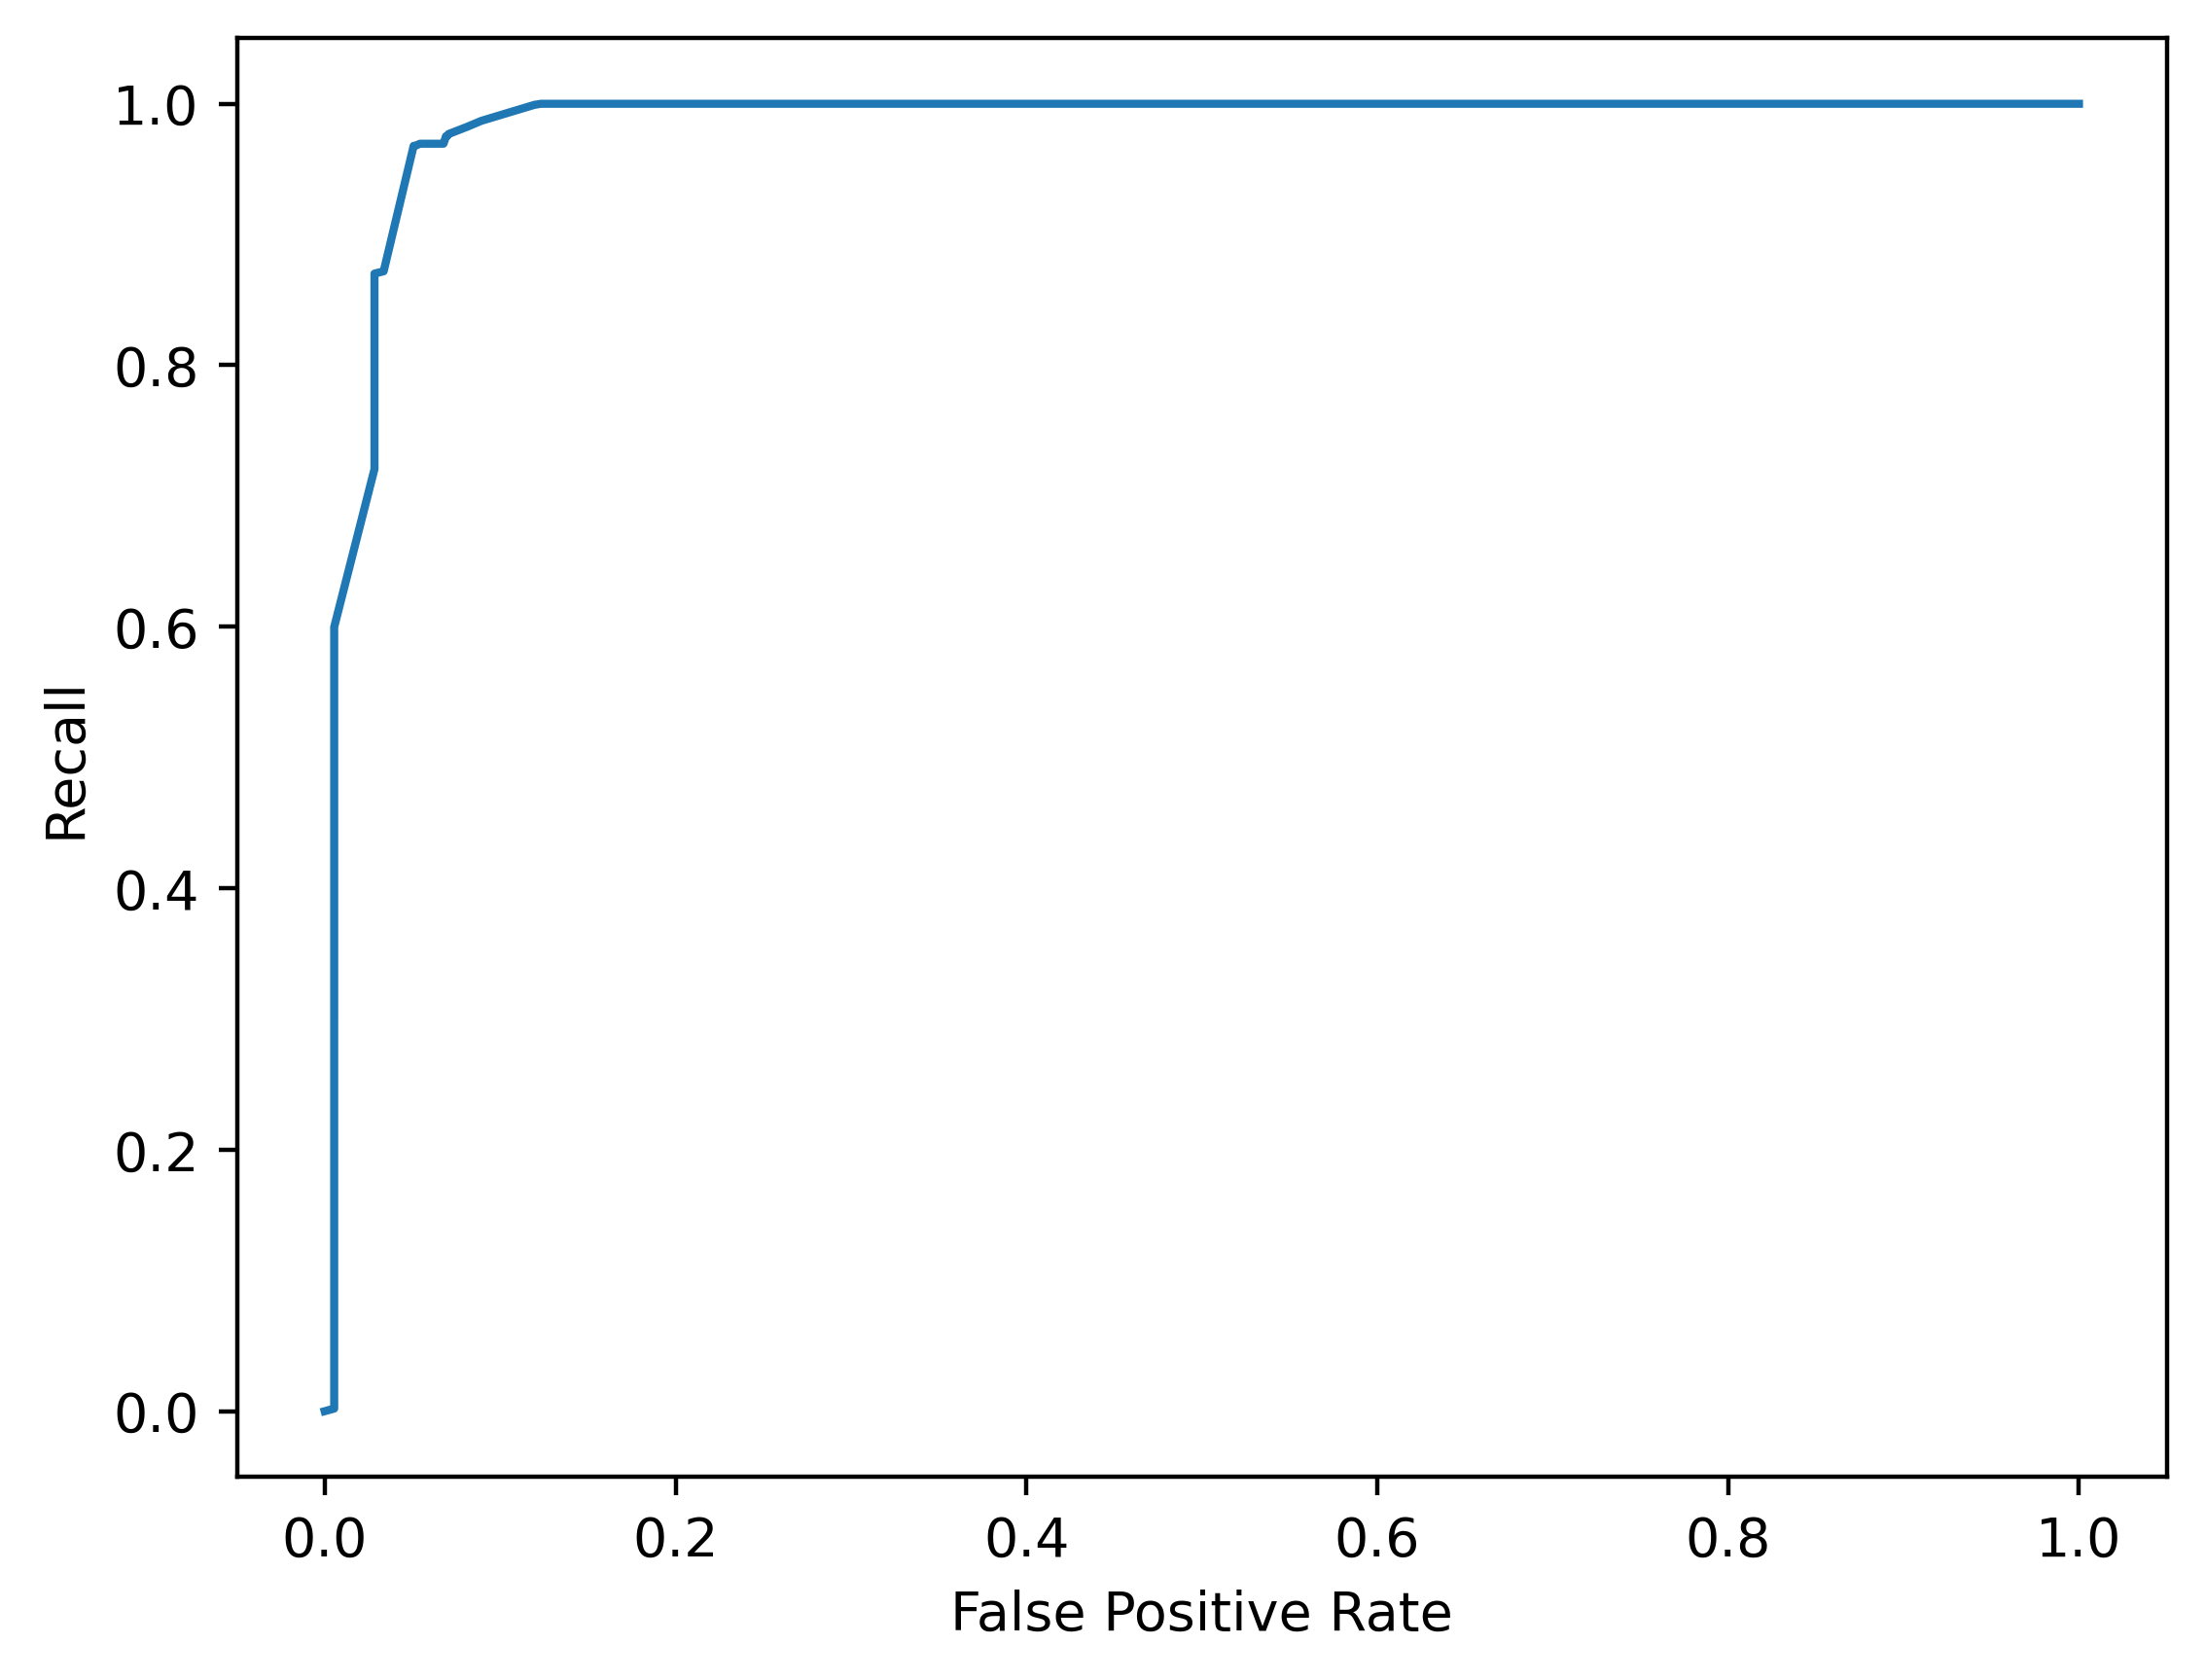

In [10]:
plt.figure(dpi=400)
fpr, tpr, _ = metrics.roc_curve(test_y,  preds_proba[:,1])
plt.plot(fpr, tpr)
plt.ylabel('Recall')
plt.xlabel('False Positive Rate')
plt.show()

#### Precision-Recall

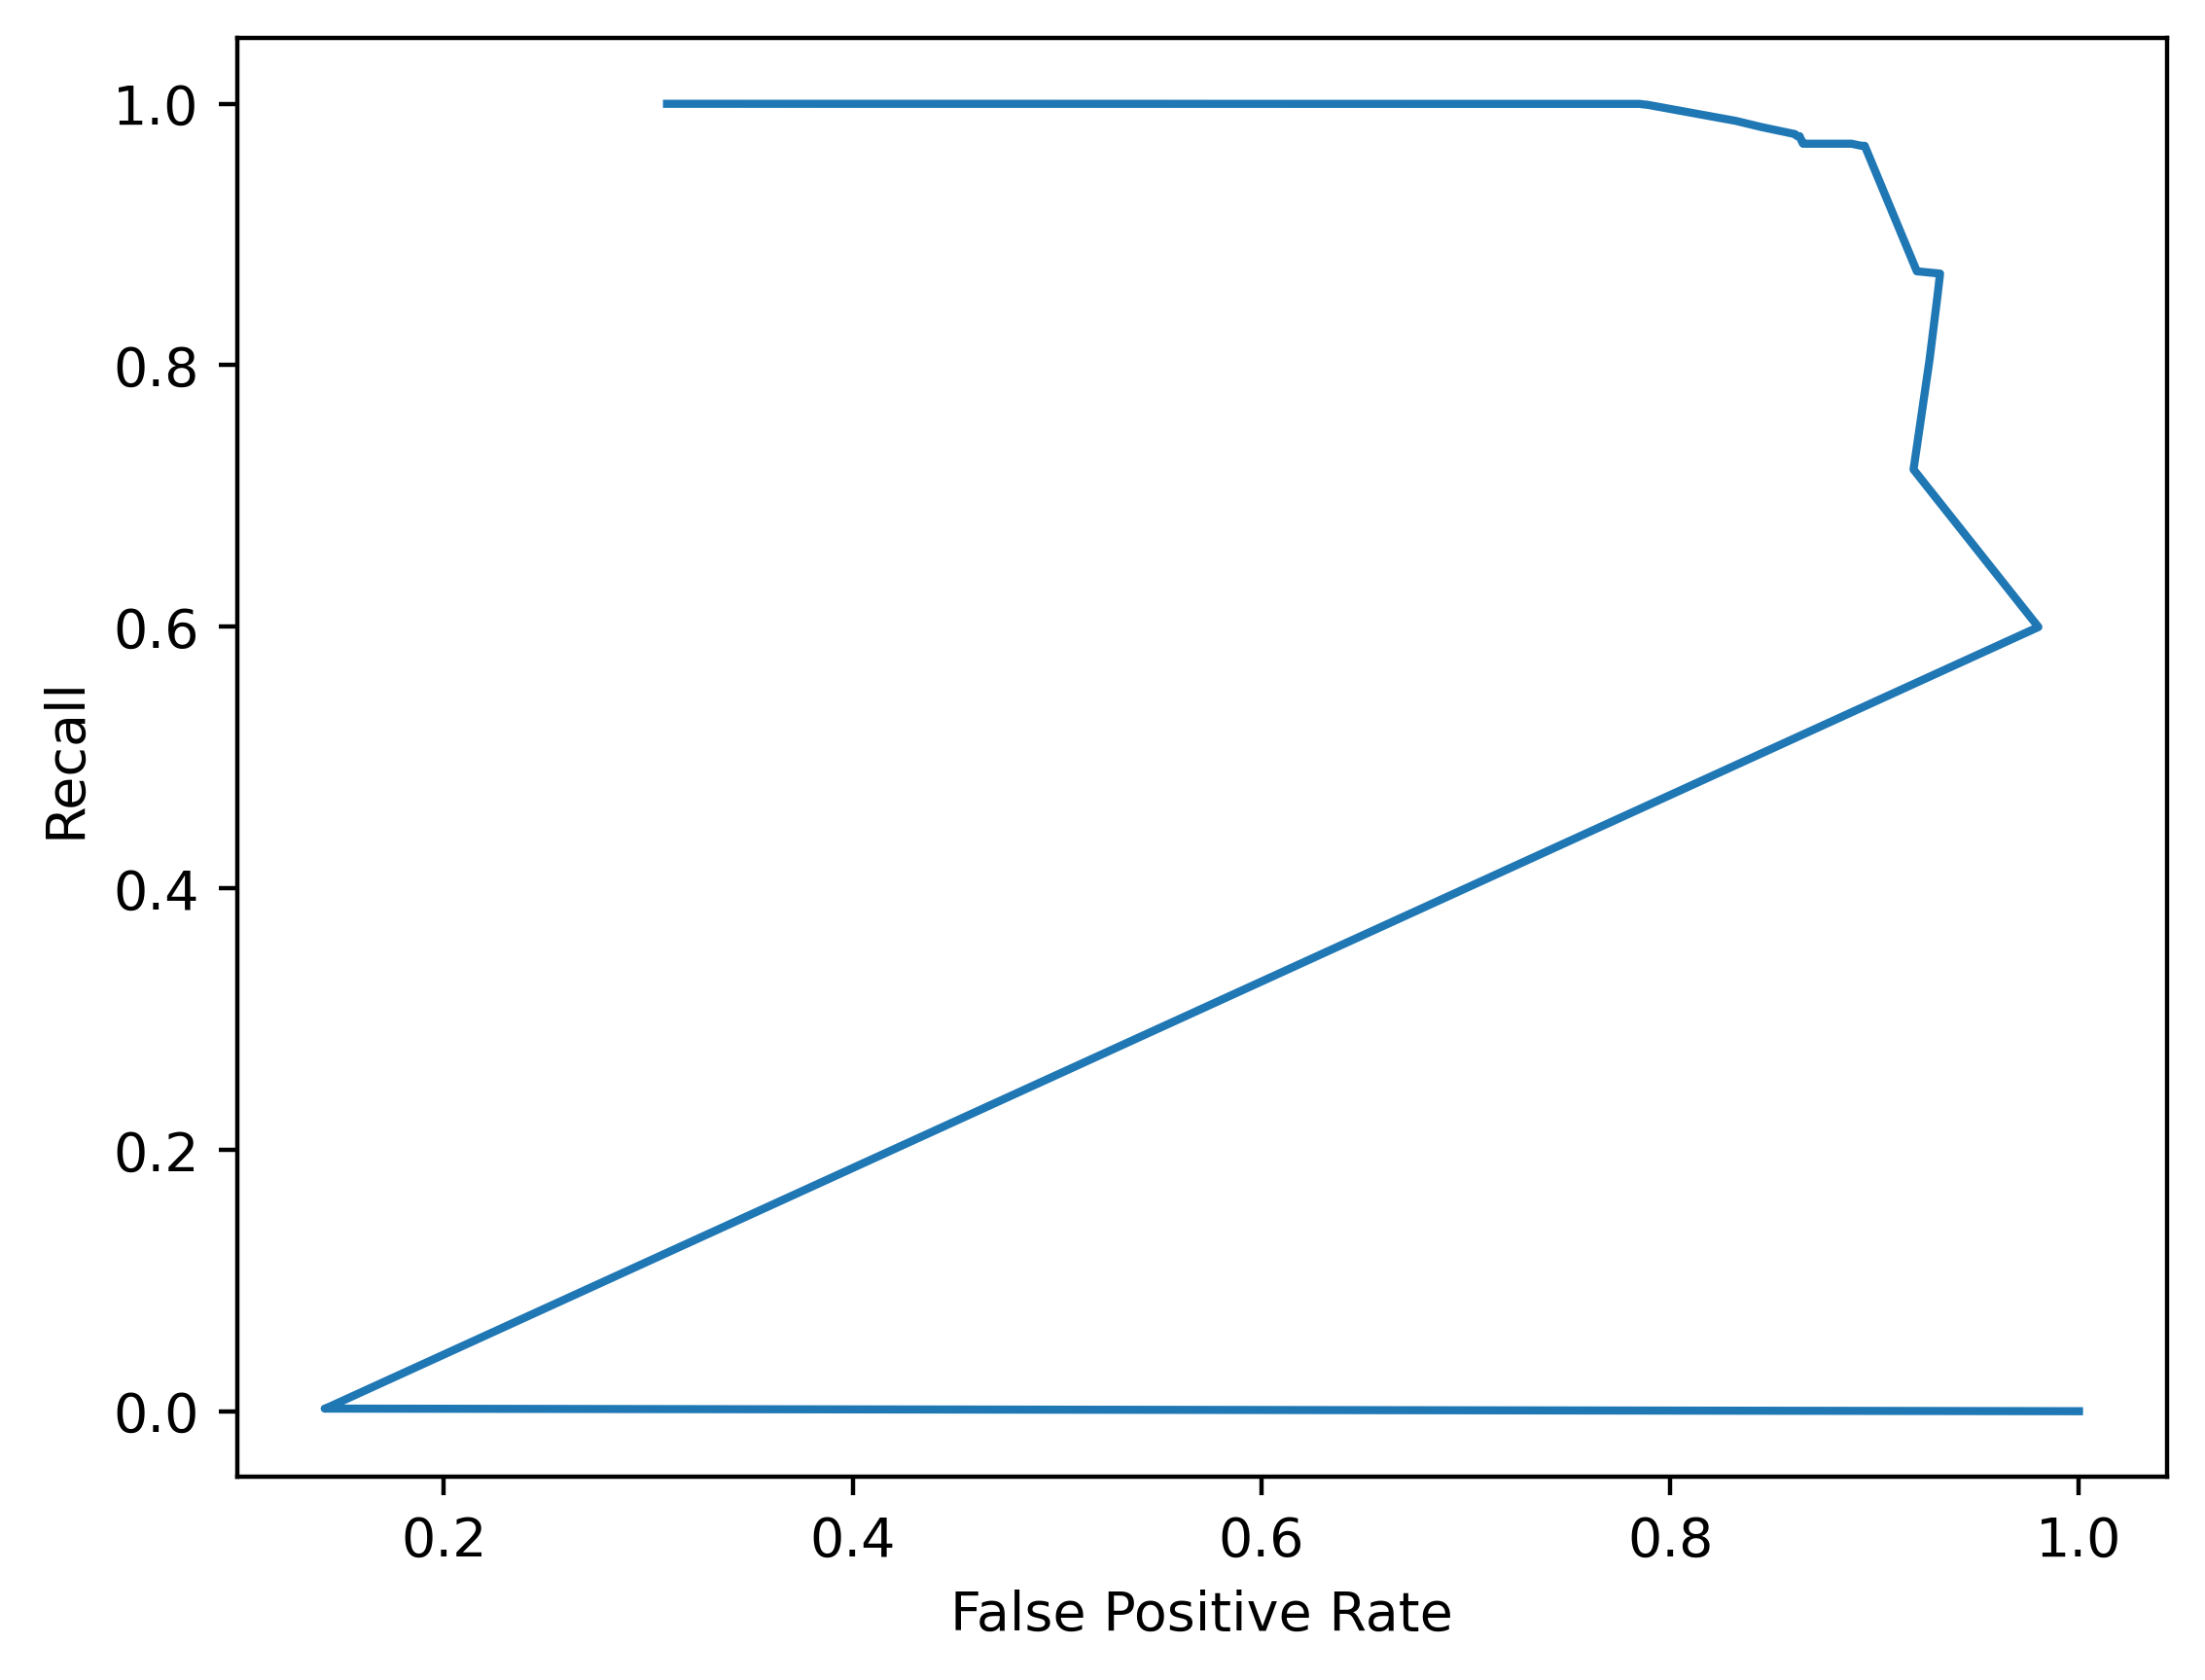

In [11]:
plt.figure(dpi=400)
fpr, tpr, _ = metrics.precision_recall_curve(test_y,  preds_proba[:,1])
plt.plot(fpr, tpr)
plt.ylabel('Recall')
plt.xlabel('False Positive Rate')
plt.show()

## Evaluate FPR / Latency trade-off

In [51]:
fpr, tpr, thresholds = metrics.roc_curve(test_y, preds_proba[:,1])

In [52]:
fpr_indexes = []
for val in DESIRED_FPR:
    index = np.argmax(fpr > val)
    fpr_indexes.append(index)    

In [53]:
fpr_thresholds = thresholds[fpr_indexes]

In [54]:
bin_preds_fpr = []
for val in fpr_thresholds:
    bin_pred = (preds_proba > val).astype(int)[:, 1]
    bin_preds_fpr.append(bin_pred)

In [55]:
bin_preds_fpr

[array([0, 0, 0, ..., 0, 0, 0], shape=(3191295,)),
 array([0, 0, 0, ..., 0, 0, 0], shape=(3191295,)),
 array([0, 0, 0, ..., 0, 0, 0], shape=(3191295,)),
 array([0, 0, 0, ..., 0, 0, 0], shape=(3191295,)),
 array([0, 0, 0, ..., 0, 1, 1], shape=(3191295,)),
 array([0, 0, 0, ..., 0, 1, 1], shape=(3191295,)),
 array([1, 0, 0, ..., 0, 1, 1], shape=(3191295,))]

In [71]:
from dateutil.parser import parse

for val, des_fpr in zip(bin_preds_fpr, DESIRED_FPR):
    
    bin_pred = val

    df_out = pd.DataFrame(columns=['start_idx_attack', 'end_idx_attack', 'attack_duration', 'time_to_detect', 'idx_detection_abs', 'idx_detection_rel', 'attack_len', 'attack_type','fpr','tpr','pr','rec','tn', 'fp','fn','tp','target_fpr', 'detected'])
    last = 0
    i = 0
    
    for seq in test_sequences_idx:
        seq_x = test_x[seq]
        seq_y = test_y[seq]
        seq_preds = bin_pred[last: last + seq_y.shape[0]]
        seq_preds = np.array(seq_preds)
    
        seq_check = test_y[last: last + seq_y.shape[0]]
        y_test_atk= np.where(test_y[seq] == 1)[0]
        y_test_norm= np.where(test_y[seq] ==  0)[0]
    
        conf_matrix = sklearn.metrics.confusion_matrix(seq_y, seq_preds)
        tn, fp, fn, tp = conf_matrix.ravel()
        print(tn)
        pr = sklearn.metrics.precision_score(seq_y, seq_preds)
        rec = sklearn.metrics.recall_score(seq_y, seq_preds)
    
        preds_1 = seq_preds[y_test_atk]
    
        date_time_0 = test_timestamp[seq[y_test_atk[0]]]
        date_time_last = test_timestamp[seq[y_test_atk[len(y_test_atk)-1]]]
        attack_time = date_time_last - date_time_0
    
        if 1 in seq_preds[y_test_atk]:
            index_rel = np.where(seq_preds[y_test_atk] == 1)[0][0]
            index = seq[y_test_atk[index_rel]]
    
            date_time_index = test_timestamp[index]
            detection_time = date_time_index - date_time_0
            detected = 1
        else:
            index_rel = len(seq) - 1
            index = seq[y_test_atk[index_rel]]
            detection_time = attack_time
            detected = 0
            
    
        df_out.loc[i] = pd.Series({'start_idx_attack': seq[y_test_atk[0]], 'end_idx_attack': seq[y_test_atk[len(y_test_atk)-1]],
                               'attack_duration': attack_time , 'time_to_detect': detection_time, 'idx_detection_abs': index,
                               'idx_detection_rel':index_rel, 'attack_len': y_test_atk.shape[0],
                               'attack_type':test_multi_label[seq[y_test_atk[0]]], 'tpr': tpr, 'pr': pr, 'rec': rec,
                               'fp':fp, 'fn':fn, 'tp':tp, 'tn':tn, 'target_fpr':des_fpr, 'detected': detected})
        last = last+len(seq_y)
        i = i+1
    
    OUT = os.path.join(TARGET_MODEL, 'results/' + str(des_fpr) + '.csv')
    df_out.to_csv(OUT, index=None)

0
0
0
0
0
0
0
0


/home/users/tommaso.puccetti/anaconda3/envs/latency/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/users/tommaso.puccetti/anaconda3/envs/latency/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/users/tommaso.puccetti/anaconda3/envs/latency/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

0
0
0
0
0
0


/home/users/tommaso.puccetti/anaconda3/envs/latency/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/users/tommaso.puccetti/anaconda3/envs/latency/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/users/tommaso.puccetti/anaconda3/envs/latency/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

0
0
0
0
0
0
0
0
0
0


/home/users/tommaso.puccetti/anaconda3/envs/latency/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/users/tommaso.puccetti/anaconda3/envs/latency/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/users/tommaso.puccetti/anaconda3/envs/latency/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

0
0
0
0
0
0
0
0
0
0
0
0
0
0


/home/users/tommaso.puccetti/anaconda3/envs/latency/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/users/tommaso.puccetti/anaconda3/envs/latency/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/users/tommaso.puccetti/anaconda3/envs/latency/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


/home/users/tommaso.puccetti/anaconda3/envs/latency/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/users/tommaso.puccetti/anaconda3/envs/latency/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/users/tommaso.puccetti/anaconda3/envs/latency/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

0
0
0
0
0
0
0
0
0
0
0


/home/users/tommaso.puccetti/anaconda3/envs/latency/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/users/tommaso.puccetti/anaconda3/envs/latency/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/users/tommaso.puccetti/anaconda3/envs/latency/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

0
0
0
0
0
0
0
0
0
0


/home/users/tommaso.puccetti/anaconda3/envs/latency/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/users/tommaso.puccetti/anaconda3/envs/latency/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/users/tommaso.puccetti/anaconda3/envs/latency/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

0
0
0
0
0
0
0
0


/home/users/tommaso.puccetti/anaconda3/envs/latency/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/users/tommaso.puccetti/anaconda3/envs/latency/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/users/tommaso.puccetti/anaconda3/envs/latency/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

0
0
0
0
0
0
0
0


/home/users/tommaso.puccetti/anaconda3/envs/latency/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/users/tommaso.puccetti/anaconda3/envs/latency/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/users/tommaso.puccetti/anaconda3/envs/latency/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

0
0
0
0
0
0
0
0
0


/home/users/tommaso.puccetti/anaconda3/envs/latency/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/users/tommaso.puccetti/anaconda3/envs/latency/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/users/tommaso.puccetti/anaconda3/envs/latency/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

0
0
0
0
0
0
0
0
0


/home/users/tommaso.puccetti/anaconda3/envs/latency/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/users/tommaso.puccetti/anaconda3/envs/latency/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/users/tommaso.puccetti/anaconda3/envs/latency/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

0
0
0
0
0
0
0
0
0
0


/home/users/tommaso.puccetti/anaconda3/envs/latency/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/users/tommaso.puccetti/anaconda3/envs/latency/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/users/tommaso.puccetti/anaconda3/envs/latency/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


/home/users/tommaso.puccetti/anaconda3/envs/latency/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/users/tommaso.puccetti/anaconda3/envs/latency/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/users/tommaso.puccetti/anaconda3/envs/latency/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


/home/users/tommaso.puccetti/anaconda3/envs/latency/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/users/tommaso.puccetti/anaconda3/envs/latency/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/users/tommaso.puccetti/anaconda3/envs/latency/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

0
0
0
0
0
0
0
0
0
0
0


/home/users/tommaso.puccetti/anaconda3/envs/latency/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/users/tommaso.puccetti/anaconda3/envs/latency/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/users/tommaso.puccetti/anaconda3/envs/latency/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

0
0
0
0
0
0
0
0
0
0


/home/users/tommaso.puccetti/anaconda3/envs/latency/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/users/tommaso.puccetti/anaconda3/envs/latency/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/users/tommaso.puccetti/anaconda3/envs/latency/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

0
0
0
0
0
0
0
0


/home/users/tommaso.puccetti/anaconda3/envs/latency/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/users/tommaso.puccetti/anaconda3/envs/latency/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/users/tommaso.puccetti/anaconda3/envs/latency/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

0
0
0
0
0
0
0
0
0
0
0


/home/users/tommaso.puccetti/anaconda3/envs/latency/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/users/tommaso.puccetti/anaconda3/envs/latency/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/users/tommaso.puccetti/anaconda3/envs/latency/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

0
0
0
0
0
0
0
0
0
0


/home/users/tommaso.puccetti/anaconda3/envs/latency/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/users/tommaso.puccetti/anaconda3/envs/latency/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/users/tommaso.puccetti/anaconda3/envs/latency/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

0
0
0
0
0
0
0
0
0
0


/home/users/tommaso.puccetti/anaconda3/envs/latency/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/users/tommaso.puccetti/anaconda3/envs/latency/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/users/tommaso.puccetti/anaconda3/envs/latency/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


/home/users/tommaso.puccetti/anaconda3/envs/latency/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/users/tommaso.puccetti/anaconda3/envs/latency/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/users/tommaso.puccetti/anaconda3/envs/latency/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


/home/users/tommaso.puccetti/anaconda3/envs/latency/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/users/tommaso.puccetti/anaconda3/envs/latency/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/users/tommaso.puccetti/anaconda3/envs/latency/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

0
0
0
0
0
0
0
0
0
0
0
0


/home/users/tommaso.puccetti/anaconda3/envs/latency/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/users/tommaso.puccetti/anaconda3/envs/latency/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/users/tommaso.puccetti/anaconda3/envs/latency/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

0
0
0
0
0
0
0
0
0
0


/home/users/tommaso.puccetti/anaconda3/envs/latency/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/users/tommaso.puccetti/anaconda3/envs/latency/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/users/tommaso.puccetti/anaconda3/envs/latency/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

0
0
0
0
0
0
0
0
0


/home/users/tommaso.puccetti/anaconda3/envs/latency/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/users/tommaso.puccetti/anaconda3/envs/latency/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/users/tommaso.puccetti/anaconda3/envs/latency/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

0
0
0
0
0
0
0
0
0
0


/home/users/tommaso.puccetti/anaconda3/envs/latency/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/users/tommaso.puccetti/anaconda3/envs/latency/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/users/tommaso.puccetti/anaconda3/envs/latency/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

0
0
0
0
0
0
0
0
0


/home/users/tommaso.puccetti/anaconda3/envs/latency/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/users/tommaso.puccetti/anaconda3/envs/latency/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/users/tommaso.puccetti/anaconda3/envs/latency/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

0
0
0
0
0
0
0
0
0
0


/home/users/tommaso.puccetti/anaconda3/envs/latency/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/users/tommaso.puccetti/anaconda3/envs/latency/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/users/tommaso.puccetti/anaconda3/envs/latency/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


/home/users/tommaso.puccetti/anaconda3/envs/latency/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/users/tommaso.puccetti/anaconda3/envs/latency/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/users/tommaso.puccetti/anaconda3/envs/latency/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


/home/users/tommaso.puccetti/anaconda3/envs/latency/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/users/tommaso.puccetti/anaconda3/envs/latency/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/users/tommaso.puccetti/anaconda3/envs/latency/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

0
0
0
0
0
0
0
0
0
0
0
0


/home/users/tommaso.puccetti/anaconda3/envs/latency/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/users/tommaso.puccetti/anaconda3/envs/latency/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/users/tommaso.puccetti/anaconda3/envs/latency/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

0
0
0
0
0
0
0
0
0
0


/home/users/tommaso.puccetti/anaconda3/envs/latency/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/users/tommaso.puccetti/anaconda3/envs/latency/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/users/tommaso.puccetti/anaconda3/envs/latency/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

0
0
0
0
0
0
0
0
0


/home/users/tommaso.puccetti/anaconda3/envs/latency/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/users/tommaso.puccetti/anaconda3/envs/latency/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/users/tommaso.puccetti/anaconda3/envs/latency/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


/home/users/tommaso.puccetti/anaconda3/envs/latency/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/users/tommaso.puccetti/anaconda3/envs/latency/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/users/tommaso.puccetti/anaconda3/envs/latency/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


/home/users/tommaso.puccetti/anaconda3/envs/latency/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/users/tommaso.puccetti/anaconda3/envs/latency/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/users/tommaso.puccetti/anaconda3/envs/latency/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


/home/users/tommaso.puccetti/anaconda3/envs/latency/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/users/tommaso.puccetti/anaconda3/envs/latency/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/users/tommaso.puccetti/anaconda3/envs/latency/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

0
0
0
0
0
0
0
0
0
0


/home/users/tommaso.puccetti/anaconda3/envs/latency/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/users/tommaso.puccetti/anaconda3/envs/latency/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


0
0
0
0
0
0
0
0
0


/home/users/tommaso.puccetti/anaconda3/envs/latency/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/users/tommaso.puccetti/anaconda3/envs/latency/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/users/tommaso.puccetti/anaconda3/envs/latency/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


/home/users/tommaso.puccetti/anaconda3/envs/latency/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/users/tommaso.puccetti/anaconda3/envs/latency/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/users/tommaso.puccetti/anaconda3/envs/latency/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


/home/users/tommaso.puccetti/anaconda3/envs/latency/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/users/tommaso.puccetti/anaconda3/envs/latency/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/users/tommaso.puccetti/anaconda3/envs/latency/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


/home/users/tommaso.puccetti/anaconda3/envs/latency/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/users/tommaso.puccetti/anaconda3/envs/latency/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/users/tommaso.puccetti/anaconda3/envs/latency/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


/home/users/tommaso.puccetti/anaconda3/envs/latency/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/users/tommaso.puccetti/anaconda3/envs/latency/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


0
0
0
0
0
0
0
0
0
0


/home/users/tommaso.puccetti/anaconda3/envs/latency/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/users/tommaso.puccetti/anaconda3/envs/latency/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/users/tommaso.puccetti/anaconda3/envs/latency/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


/home/users/tommaso.puccetti/anaconda3/envs/latency/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/users/tommaso.puccetti/anaconda3/envs/latency/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/users/tommaso.puccetti/anaconda3/envs/latency/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


/home/users/tommaso.puccetti/anaconda3/envs/latency/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/users/tommaso.puccetti/anaconda3/envs/latency/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/users/tommaso.puccetti/anaconda3/envs/latency/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

0
0
0
0
0
0
0
0
0
0
0
0
0


/home/users/tommaso.puccetti/anaconda3/envs/latency/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/users/tommaso.puccetti/anaconda3/envs/latency/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/users/tommaso.puccetti/anaconda3/envs/latency/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

0
0
0
0
0
0
0
0
0
0
0
0


/home/users/tommaso.puccetti/anaconda3/envs/latency/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/users/tommaso.puccetti/anaconda3/envs/latency/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


/home/users/tommaso.puccetti/anaconda3/envs/latency/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/users/tommaso.puccetti/anaconda3/envs/latency/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/users/tommaso.puccetti/anaconda3/envs/latency/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo